# Imports

In [1]:
# imports
import sys
sys.path.append('..')
from functions import *
from geometry import *
from networks import *
from plotting import *
from transforms import *
from distribution import *
from statistical import *

In [2]:
import os
# Change to the directory where the train folder is located
os.chdir('../writeup_notebooks_example')
# Verify the change
print("New Working Directory:", os.getcwd())

New Working Directory: /Users/giuliofilippi/Documents/Code/fpm-paper/writeup_notebooks_example


In [3]:
# import matplotlib
import matplotlib.pyplot as plt

# format sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 15

# matplotlib params
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['xtick.direction'] = 'out' # ticks points outwards
plt.rcParams['lines.linewidth'] = 2.0 # bigger linewidth
plt.rcParams['svg.fonttype'] = 'none' # matplotlib svg text setting

# Initialize Colony

In [4]:
# params
n_vpn = 20*90
n_kc = 25000
k = 8
p = 0.05
q_l = None # only useful if initialising weights
q_r = None # only useful if initialising weights
alpha = 0.95
mode="top"
init_weights=False
weight_mode='1'
training_mode='exp'
epsilon=0

In [5]:
# list of models
colony_size = 50
colony = []

for i in range(colony_size):
    # initialize
    model = LRMBNetwork(
                    n_vpn, 
                    n_kc, 
                    k, 
                    p, 
                    q_l, 
                    q_r, 
                    alpha, 
                    mode, 
                    init_weights, 
                    weight_mode, 
                    training_mode,
                    epsilon)
    # load weights
    model.LeftMB.load_weights('../params_fwd/DS/ant_{}_L.pth'.format(i))
    model.RightMB.load_weights('../params_fwd/DS/ant_{}_R.pth'.format(i))
    # append to colony
    colony.append(model)

print (len(colony))

50


# Base Shape

In [6]:
train_path = np.load('../paths/train/path_1a.npy')
train_image = train_path[0]
FPM = compute_fpm(train_image)
FPM

0.1875

<Axes: title={'center': 'Image'}, xlabel='X-axis', ylabel='Y-axis'>

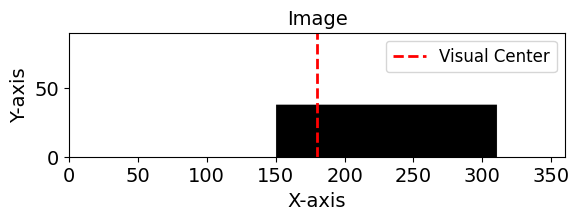

In [7]:
plot_image(train_image)

In [8]:
train_path_down = [downsample_and_flatten_transform(arr) for arr in train_path]

In [9]:
# train all 50 models on train image
for model in colony:
    model.LeftMB.initialize_output_weights()
    model.RightMB.initialize_output_weights()
    model.train_network(train_path_down)

/Users/giuliofilippi/Documents/Code/fpm-paper/writeup_notebooks_example/../networks.py:270: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  image_sequence = torch.Tensor(image_sequence).unsqueeze(1)


# Test One Rectangle

In [10]:
# load test image
test_rotations = np.load('../paths/test/image_1b_rotations.npy')
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180

<Axes: title={'center': 'Image'}, xlabel='X-axis', ylabel='Y-axis'>

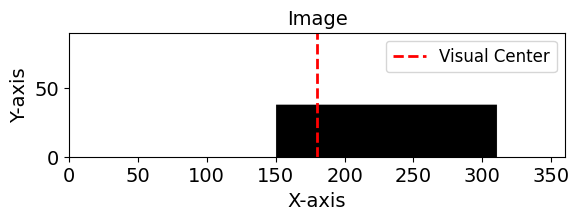

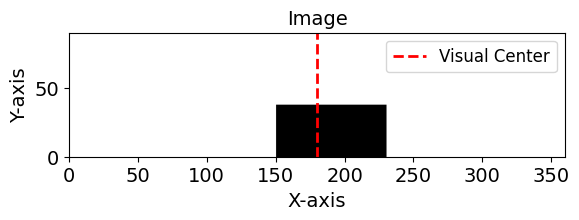

In [11]:
plot_image(train_image)
plot_image(test_image)

In [12]:
# get test rotations 1
test_rotations_transformed = [downsample_and_flatten_transform(arr) for arr in test_rotations]
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_transformed]
rotation_tensor = torch.stack(rotation_tensor)

# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

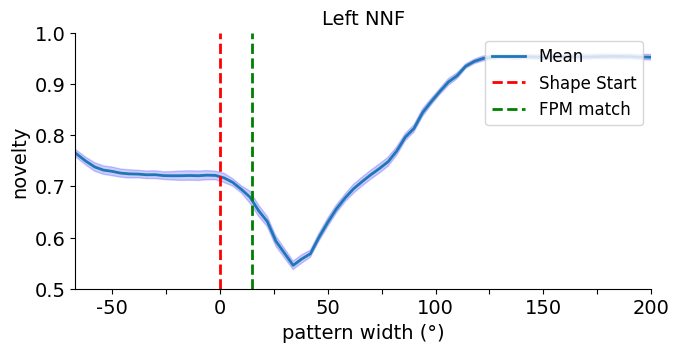

In [13]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 30
i = 0

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.ylim(0.5, 1)  # y lim 0.5 to 1
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports_example/left.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

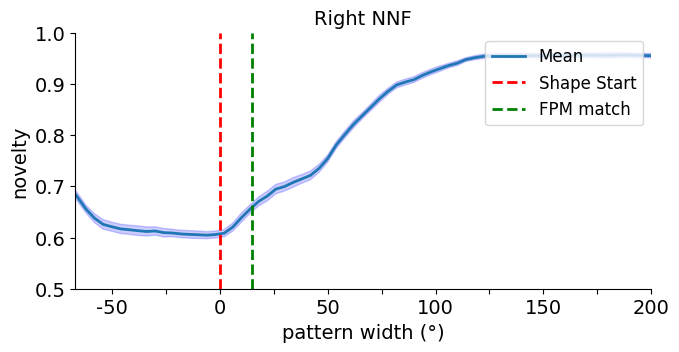

In [14]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 30
i = 1

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.ylim(0.5, 1)  # y lim 0.5 to 1
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports_example/right.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

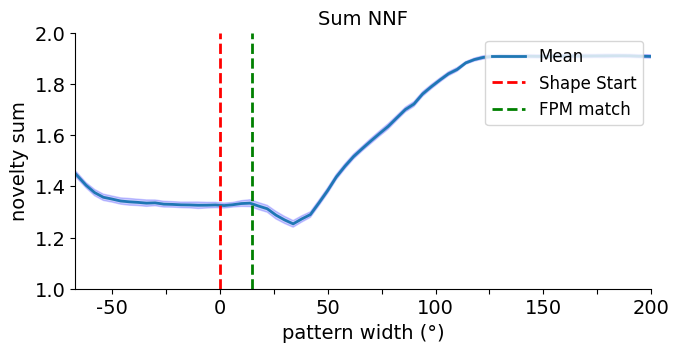

In [15]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 30
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.ylim(1, 2)  # y lim 0.5 to 1
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports_example/sum.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

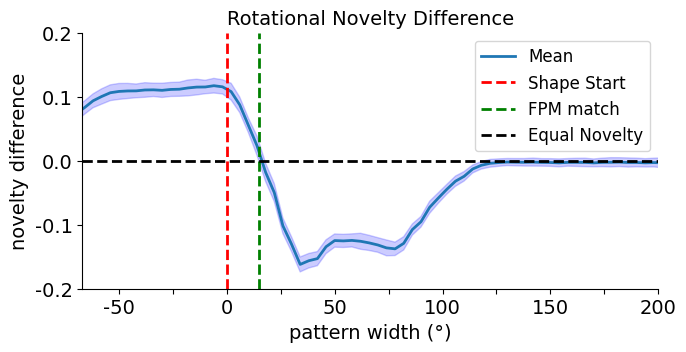

In [16]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 30
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.ylim(-0.2, 0.2)  # y lim 0.5 to 1
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports_example/diff.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [17]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

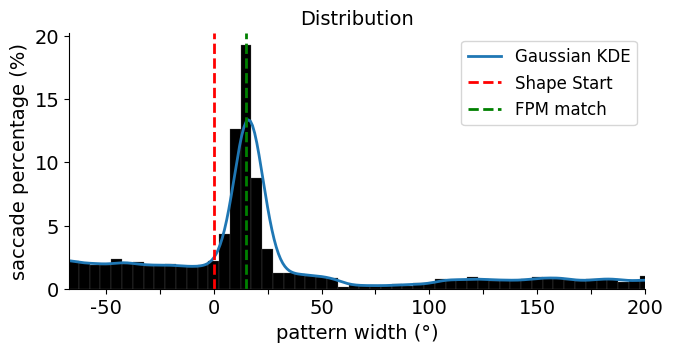

In [18]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.2)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports_example/dist.svg", format="svg", bbox_inches='tight')

# show
plt.show()